In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam



In [5]:
INPUT_DIR = 'Dataset_BUSI_with_GT'
OUTPUT_DIR = '/kaggle/working/preprocessed_balanced_dataset'
TARGET_SIZE = (224, 224)
TARGET_COUNT = 891
CLASSES = ['benign', 'malignant', 'normal']

In [6]:
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, TARGET_SIZE)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.bilateralFilter(image, 9, 75, 75)
    return image

def save_preprocessed_images(class_name):
    input_path = os.path.join(INPUT_DIR, class_name)
    output_path = os.path.join(OUTPUT_DIR, class_name)
    os.makedirs(output_path, exist_ok=True)

    image_files = [f for f in os.listdir(input_path) if f.endswith('.png') and 'mask' not in f]
    count = 0

    for i, filename in enumerate(tqdm(image_files, desc=f"Preprocessing {class_name}")):
        if count >= TARGET_COUNT:
            break
        img_path = os.path.join(input_path, filename)
        processed = preprocess_image(img_path)
        cv2.imwrite(os.path.join(output_path, f"{class_name}_{i}.png"), processed)
        count += 1

    return output_path, count

def augment_class_images(class_name, current_count):
    if current_count >= TARGET_COUNT:
        return
    
    datagen = ImageDataGenerator(
        rotation_range=15,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    class_dir = os.path.join(OUTPUT_DIR, class_name)
    images = [f for f in os.listdir(class_dir) if f.endswith('.png')]
    img_idx = 0
    while current_count < TARGET_COUNT:
        img_path = os.path.join(class_dir, images[img_idx % len(images)])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.reshape((1, img.shape[0], img.shape[1], 1))
        for batch in datagen.flow(img, batch_size=1, save_to_dir=class_dir,
                                  save_prefix='aug', save_format='png'):
            current_count += 1
            if current_count >= TARGET_COUNT:
                break
        img_idx += 1

for cls in CLASSES:
    out_dir, count = save_preprocessed_images(cls)
    print(f"{cls} class before augmentation: {count} images")
    augment_class_images(cls, count)
    final_count = len([f for f in os.listdir(out_dir) if f.endswith('.png')])
    print(f"{cls} class after augmentation: {final_count} images")

print("\nProcessing and balancing have been completed.")

Preprocessing benign: 100%|██████████| 437/437 [00:09<00:00, 47.48it/s]


benign class before augmentation: 437 images
benign class after augmentation: 885 images


Preprocessing malignant: 100%|██████████| 210/210 [00:04<00:00, 47.87it/s]


malignant class before augmentation: 210 images
malignant class after augmentation: 859 images


Preprocessing normal: 100%|██████████| 133/133 [00:02<00:00, 46.05it/s]


normal class before augmentation: 133 images
normal class after augmentation: 857 images

Processing and balancing have been completed.


In [7]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import shutil

# Paths and settings
INPUT_DIR = 'Dataset_BUSI_with_GT'
OUTPUT_DIR = '/kaggle/working/preprocessed_balanced_dataset'
TARGET_SIZE = (224, 224)
TARGET_COUNT = 891
CLASSES = ['benign', 'malignant', 'normal']

# Clean previous outputs
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------- SEGMENTATION FUNCTION ---------------------- #
def apply_kmeans_segmentation(image, k=2):
    Z = image.reshape((-1, 1)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    segmented_img = centers[labels.flatten()].reshape(image.shape)
    segmented_img = np.uint8(segmented_img)
    return segmented_img

# ---------------------- PREPROCESSING FUNCTION ---------------------- #
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, TARGET_SIZE)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = apply_kmeans_segmentation(image) 
    return image

# ---------------------- SAVE IMAGES FUNCTION ---------------------- #
def save_preprocessed_images(class_name):
    input_path = os.path.join(INPUT_DIR, class_name)
    output_path = os.path.join(OUTPUT_DIR, class_name)
    os.makedirs(output_path, exist_ok=True)

    image_files = [f for f in os.listdir(input_path) if f.endswith('.png') and 'mask' not in f]
    count = 0

    for i, filename in enumerate(tqdm(image_files, desc=f"Preprocessing {class_name}")):
        if count >= TARGET_COUNT:
            break
        img_path = os.path.join(input_path, filename)
        processed = preprocess_image(img_path)
        cv2.imwrite(os.path.join(output_path, f"{class_name}_{i}.png"), processed)
        count += 1

    return output_path, count

# ---------------------- AUGMENTATION FUNCTION ---------------------- #
def augment_class_images(class_name, current_count):
    if current_count >= TARGET_COUNT:
        return

    datagen = ImageDataGenerator(
        rotation_range=15,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    class_dir = os.path.join(OUTPUT_DIR, class_name)
    images = [f for f in os.listdir(class_dir) if f.endswith('.png')]
    img_idx = 0

    while current_count < TARGET_COUNT:
        img_path = os.path.join(class_dir, images[img_idx % len(images)])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.reshape((1, img.shape[0], img.shape[1], 1))
        for batch in datagen.flow(img, batch_size=1, save_to_dir=class_dir,
                                  save_prefix='aug', save_format='png'):
            current_count += 1
            if current_count >= TARGET_COUNT:
                break
        img_idx += 1

# ---------------------- MAIN PREPROCESS + AUGMENT ---------------------- #
for cls in CLASSES:
    out_dir, count = save_preprocessed_images(cls)
    print(f"{cls} class before augmentation: {count} images")
    augment_class_images(cls, count)
    final_count = len([f for f in os.listdir(out_dir) if f.endswith('.png')])
    print(f"{cls} class after augmentation: {final_count} images")

print("\n✅ Processing and balancing completed.")

# ---------------------- MODEL DEFINITION ---------------------- #
IMG_SIZE = 224
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  
])
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n CNN model defined and compiled.")

Preprocessing benign: 100%|██████████| 437/437 [00:13<00:00, 33.27it/s]


benign class before augmentation: 437 images
benign class after augmentation: 882 images


Preprocessing malignant: 100%|██████████| 210/210 [00:05<00:00, 36.78it/s]


malignant class before augmentation: 210 images
malignant class after augmentation: 864 images


Preprocessing normal: 100%|██████████| 133/133 [00:03<00:00, 36.27it/s]


normal class before augmentation: 133 images
normal class after augmentation: 866 images

✅ Processing and balancing completed.

 CNN model defined and compiled.


c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    OUTPUT_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 2091 images belonging to 3 classes.


In [9]:
val_generator = datagen.flow_from_directory(
    OUTPUT_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


loss, acc = model.evaluate(val_generator)
print(f"\nFinal Accuracy: {acc:.4f}, Loss: {loss:.4f}")

Found 521 images belonging to 3 classes.


c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 48s 718ms/step - accuracy: 0.6754 - loss: 1.3655 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 438ms/step - accuracy: 0.9062 - loss: 0.2523 - val_accuracy: 1.0000 - val_loss: 4.3016e-04
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 459ms/step - accuracy: 0.9799 - loss: 0.0764 - val_accuracy: 0.9962 - val_loss: 0.0078
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 472ms/step - accuracy: 0.9917 - loss: 0.0307 - val_accuracy: 0.9942 - val_loss: 0.0184
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 485ms/step - accuracy: 0.9963 - loss: 0.0154 - val_accuracy: 0.9923 - val_loss: 0.0384
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 490ms/step - accuracy: 0.9970 - loss: 0.0114 - val_accuracy: 0.9942 - val_loss: 0.0164
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 486ms/step - accuracy: 0.9988 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 4.7840e-04
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 554ms/step - accuracy: 0.9989 - loss: 0.0058 - 

Found 2091 images belonging to 3 classes.
Found 521 images belonging to 3 classes.
Class Weights: {0: np.float64(0.9872521246458924), 1: np.float64(1.0072254335260116), 2: np.float64(1.0057720057720059)}
Epoch 1/10


c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 418ms/step - accuracy: 0.7128 - loss: 1.0116 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 464ms/step - accuracy: 0.8897 - loss: 0.3026 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 484ms/step - accuracy: 0.9541 - loss: 0.1279 - val_accuracy: 0.9846 - val_loss: 0.0274
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 497ms/step - accuracy: 0.9870 - loss: 0.0559 - val_accuracy: 1.0000 - val_loss: 1.3818e-04
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 496ms/step - accuracy: 0.9907 - loss: 0.0413 - val_accuracy: 1.0000 - val_loss: 2.4568e-04
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 494ms/step - accuracy: 0.9934 - loss: 0.0199 - val_accuracy: 1.0000 - val_loss: 6.9498e-05
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 496ms/step - accuracy: 0.9985 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 6.4154e-05
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 500ms/step - accuracy: 0.9992 - loss: 0.0049 - val

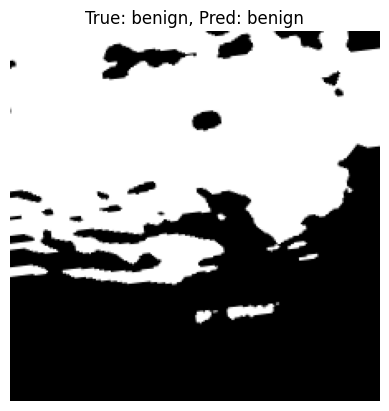

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


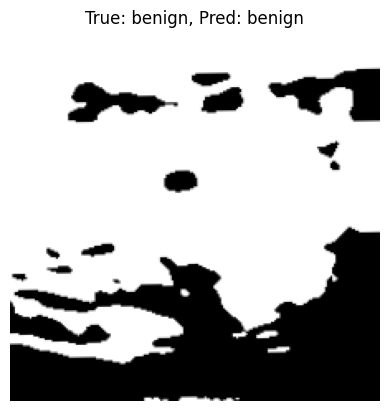

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


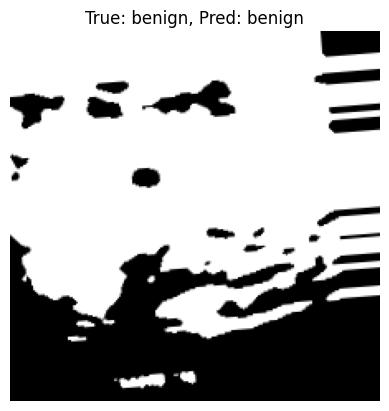

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# --- CONFIGURATION ---
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
OUTPUT_DIR = '/kaggle/working/preprocessed_balanced_dataset'  # <-- change this if needed

# --- Data Generators ---
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    OUTPUT_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    OUTPUT_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# --- Class Weights ---
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# --- Simple CNN Model ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes: benign, malignant, normal
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train Model ---
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weight_dict
)

# --- Evaluate Model ---
loss, acc = model.evaluate(val_generator)
print(f"\n✅ Final Accuracy: {acc:.4f}, Loss: {loss:.4f}")

# --- Classification Metrics ---
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(val_generator.class_indices.keys())

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_true, y_pred))

# --- Optional: Visualize a Few Predictions ---
x_sample, y_sample = next(val_generator)
for i in range(3):
    plt.imshow(x_sample[i].squeeze(), cmap='gray')
    pred_label = class_labels[np.argmax(model.predict(x_sample[i:i+1]))]
    true_label = class_labels[np.argmax(y_sample[i])]
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()


In [17]:
import os, shutil
import random

def split_data(input_dir, output_base_dir, split_ratio=0.2):
    random.seed(42)
    classes = os.listdir(input_dir)
    
    for cls in classes:
        img_dir = os.path.join(input_dir, cls)
        imgs = [f for f in os.listdir(img_dir) if f.endswith('.png')]
        random.shuffle(imgs)
        split_point = int(len(imgs) * (1 - split_ratio))
        
        train_imgs = imgs[:split_point]
        val_imgs = imgs[split_point:]
        
        for subdir, filelist in zip(['train', 'val'], [train_imgs, val_imgs]):
            save_path = os.path.join(output_base_dir, subdir, cls)
            os.makedirs(save_path, exist_ok=True)
            for f in filelist:
                shutil.copy(os.path.join(img_dir, f), os.path.join(save_path, f))

# Run this only once
split_data('/kaggle/working/preprocessed_balanced_dataset', '/kaggle/working/split_dataset')


Found 2088 images belonging to 3 classes.
Found 524 images belonging to 3 classes.
Class Weights: {0: np.float64(0.9872340425531915), 1: np.float64(1.0072358900144718), 2: np.float64(1.0057803468208093)}


c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 58s 861ms/step - accuracy: 0.7721 - loss: 7.5980 - val_accuracy: 0.5344 - val_loss: 0.8381
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 856ms/step - accuracy: 0.8764 - loss: 0.6117 - val_accuracy: 0.3912 - val_loss: 1.3550
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 60s 905ms/step - accuracy: 0.8674 - loss: 0.2747 - val_accuracy: 0.5992 - val_loss: 0.9730
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 894ms/step - accuracy: 0.8905 - loss: 0.2766 - val_accuracy: 0.5267 - val_loss: 1.0273
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 900ms/step - accuracy: 0.8948 - loss: 0.2190 - val_accuracy: 0.7786 - val_loss: 0.6206
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 897ms/step - accuracy: 0.8789 - loss: 0.2553 - val_accuracy: 0.8550 - val_loss: 0.3805
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 892ms/step - accuracy: 0.8788 - loss: 0.7173 - val_accuracy: 0.8492 - val_loss: 3.3652
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 892ms/step - accuracy: 0.8588 - loss: 0.7464 - val_accu

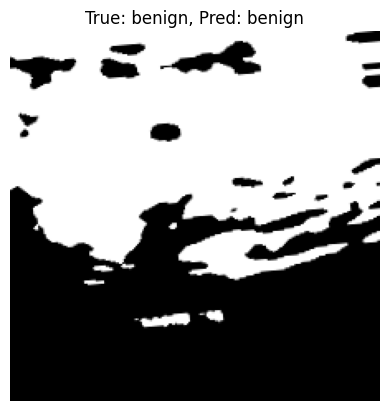

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


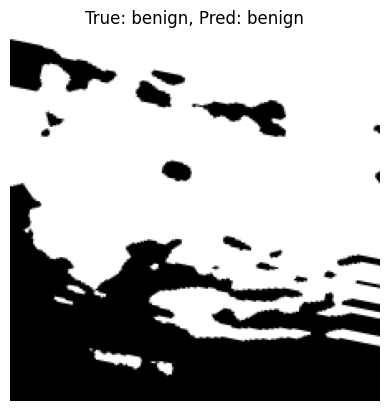

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


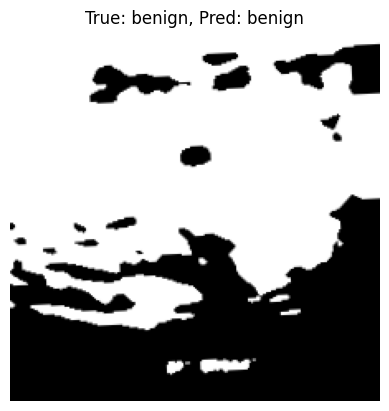

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# --- CONFIGURATION ---
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
DATASET_DIR = '/kaggle/working/split_dataset'

# --- Data Generators ---
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- Class Weights ---
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# --- CNN Model ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train Model ---
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weight_dict
)

# --- Evaluate Model ---
loss, acc = model.evaluate(val_generator)
print(f"\n✅ Final Accuracy: {acc:.4f}, Loss: {loss:.4f}")

# --- Classification Report ---
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(val_generator.class_indices.keys())

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_true, y_pred))

# --- Visualize Predictions ---
x_sample, y_sample = next(val_generator)
for i in range(3):
    plt.imshow(x_sample[i].squeeze(), cmap='gray')
    pred_label = class_labels[np.argmax(model.predict(x_sample[i:i+1]))]
    true_label = class_labels[np.argmax(y_sample[i])]
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()
